In [39]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
from torchvision.transforms import transforms
from torchvision import  transforms, models
from torchsummary import summary
from PIL import Image 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型和权重

In [41]:
model = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last `n` layers
n = 3
for child in list(model.children())[-n:]:
    for param in child.parameters():
        param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [42]:
def load_best_model(model, path='best_model.pth'):
    model.load_state_dict(torch.load(path))
    print("Best model loaded from", path)

In [43]:
load_best_model(model)
summary(model,(3, 224, 224))

Best model loaded from best_model.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
 

# 读取数据

In [44]:
main_path = 'archive/Driver Drowsiness Dataset (DDD)/'

drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

paths = drowsy_paths +  non_drowsy_paths

random.shuffle(paths)

total_size = len(paths)

In [45]:
import re

def extract_class_name(p):
    return re.split(r'[/\\]', p)[-2]

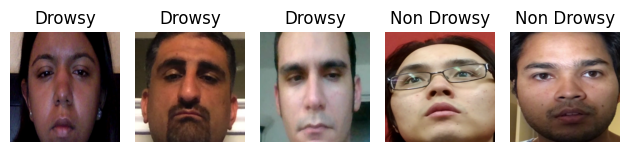

['archive/Driver Drowsiness Dataset (DDD)/Drowsy\\H0319.png',
 'archive/Driver Drowsiness Dataset (DDD)/Drowsy\\A0790.png',
 'archive/Driver Drowsiness Dataset (DDD)/Drowsy\\L0295.png',
 'archive/Driver Drowsiness Dataset (DDD)/Non Drowsy\\n0947.png',
 'archive/Driver Drowsiness Dataset (DDD)/Non Drowsy\\s0098.png']

In [46]:
def show_images_with_labels(paths, num_images):
    plt.figure()
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

NUM_IMAGES = 5
pred_path=paths[:NUM_IMAGES]
show_images_with_labels(pred_path, num_images=NUM_IMAGES)
pred_path

# 预测

In [47]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [48]:
class PredictionDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

predict_dataset = PredictionDataset(pred_path, transform=transform)
predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False, num_workers=0)

model.eval()
all_preds = []

print(f"Total batches: {len(predict_loader)}")

with torch.no_grad():
    for imgs in predict_loader:
        imgs = imgs.to(device)
        predictions = model(imgs)
        _, preds = torch.max(predictions, 1)
        all_preds.extend('drowsy' if pred == 0 else 'non drowsy' for pred in preds.cpu().numpy().tolist())

print(f"Total predictions: {len(all_preds)}")
print(all_preds)

Total batches: 1
Total predictions: 5
['non drowsy', 'drowsy', 'drowsy', 'non drowsy', 'non drowsy']


In [49]:
def show_images_with_labels_and_predictions(paths):
    plt.figure()
    num_images = len(paths)
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        prediction = all_preds[i]
        plt.subplot(num_images,1, i + 1)
        plt.imshow(img)
        plt.title(f'label: {label}, prediction: {prediction}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

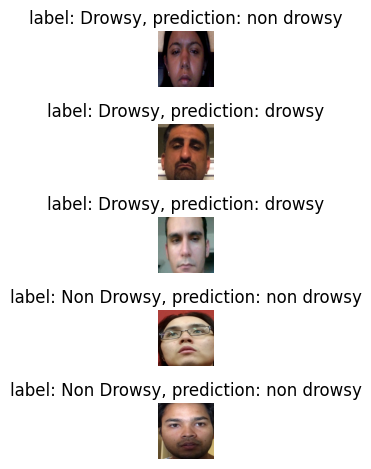

In [50]:
show_images_with_labels_and_predictions(pred_path)